In [1]:
import os
import cv2
import numpy
import pandas
import pickle
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
### Constants
TRAIN_PATH = "./dataset_no0_w_new_data/train_data" # path to the dataset
TEST_PATH = "./dataset_no0_w_new_data/test_data" # path to the dataset
VAL_PATH = "./dataset_no0_w_new_data/val_data" # path to the dataset
LABEL_PATH = './media/labels_no0.csv' # path to the labels csv file
RESULT_PATH = "dataloader" + "_" + "max" + "_" + "3x5-3x3" + "_" + "dataset_no0_530sxe_w_new_data" # path to the labels csv file
BATCH_SIZE_VAL = 64 # size of batches during training
STEPS_X_EPOCH = 530 # number of steps per epoch
N_EPOCHS = 100 # number of epochs for training
IMG_DIM = (32,32,3) # dimensions of the images (height, width, channels)

In [3]:
### Functions
def sorted_imagefolder(root, transform):
	# Ensure the folder names are sorted numerically, if find file ".DS_Store" remove it
	if ".DS_Store" in os.listdir(root):
		os.remove(os.path.join(root, ".DS_Store"))
	
	# Sort the folder names numerically
	folder_names = sorted(os.listdir(root), key=lambda x: int(x))

	# Create a mapping of folder names to numeric labels
	class_to_idx = {folder: idx for idx, folder in enumerate(folder_names)}

	# Create an ImageFolder instance
	dataset = datasets.ImageFolder(root=root, transform=transform)

	# Override the class_to_idx to match the sorted order
	dataset.class_to_idx = class_to_idx

	# Update the dataset to ensure it uses our sorted classes
	dataset.classes = folder_names  # Update classes attribute
	dataset.samples = [(os.path.join(root, folder, f), class_to_idx[folder]) 
					for folder in folder_names 
					for f in os.listdir(os.path.join(root, folder))]

	return dataset

def grayscale(img):
	import torchvision.transforms as transforms
	from torchvision.transforms import functional
	"""function to convert the image to grayscale"""
	if img is None or not isinstance(img, numpy.ndarray) or len(img.shape) == 2:  # Assuming 'grayscale' starts here
		return img  # return it as is
	else:
		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
		return img

def equalize(img):
	"""Function to equalize the histogram for contrast adjustment."""
	if img is None:
		return img  # Return None as is

	# Check if img is a tensor and convert to NumPy array
	if isinstance(img, torch.Tensor):
		img = img.detach().cpu().numpy()  # Convert to NumPy array

	if not isinstance(img, numpy.ndarray):
		print("Received non-array image: ", type(img))
		return img

	img = img.astype(numpy.uint8)  # Ensure the image is 8-bit grayscale
	img = cv2.equalizeHist(img)  # Apply histogram equalization

	return img

In [4]:
### Classes
class CustomTransform:
	"""Custom transformation class to apply grayscale, histogram equalization, and normalization."""
	def __init__(self):
		pass

	def __call__(self, img):
		# Apply the custom transformations
		img = grayscale(img) # convert to grayscale
		img = equalize(img) # equalize histogram
		img = img / 255 # normalize pixel values to the range [0, 1] instead of [0, 255]
		return img

class TrafficSignModel:
	def __init__(self, n_classes, img_dim, n_kernels=60, n_nodes=500, kernel_size_5x5=(5, 5), 
				 kernel_size_3x3=(3, 3), pool_size=(2, 2), dropout_rate=0.5, learning_rate=0.001):
		"""
		Initializes the TSignModel class with the specified parameters.
		
		Parameters:
		- n_classes (int): Number of output classes.
		- img_dim (tuple): Dimensions of the input images (height, width, channels).
		- n_kernels (int): Number of kernels for convolutional layers.
		- n_nodes (int): Number of nodes in the fully connected layer.
		- kernel_size_5x5 (tuple): Size of the first convolutional kernel.
		- kernel_size_3x3 (tuple): Size of the second convolutional kernel.
		- pool_size (tuple): Size of the pooling window.
		- dropout_rate (float): Rate of dropout for regularization.
		- learning_rate (float): Learning rate for the optimizer.
		"""
		self.n_classes = n_classes
		self.img_dim = img_dim
		self.n_kernels = n_kernels
		self.n_nodes = n_nodes
		self.kernel_size_5x5 = kernel_size_5x5
		self.kernel_size_3x3 = kernel_size_3x3
		self.pool_size = pool_size
		self.dropout_rate = dropout_rate
		self.learning_rate = learning_rate
		self.model = self._build_model()

	def _build_model(self):
		"""Defines the CNN model."""
		model = Sequential()

		# # First convolutional block
		# model.add(Conv2D(self.n_kernels, self.kernel_size_5x5, input_shape=(self.img_dim[0], self.img_dim[1], 1), activation='relu'))
		# model.add(Conv2D(self.n_kernels, self.kernel_size_5x5, activation='relu'))  # 2nd conv layer
		# model.add(Conv2D(self.n_kernels, self.kernel_size_5x5, activation='relu'))  # 2nd conv layer
		# model.add(MaxPooling2D(pool_size=self.pool_size))  # max pooling layer

		# # Second convolutional block
		# model.add(Conv2D(self.n_kernels // 2, self.kernel_size_3x3, activation='relu'))  # 3rd conv layer
		# model.add(Conv2D(self.n_kernels // 2, self.kernel_size_3x3, activation='relu'))  # 4th conv layer
		# model.add(Conv2D(self.n_kernels // 2, self.kernel_size_3x3, activation='relu'))  # 4th conv layer
		# model.add(MaxPooling2D(pool_size=self.pool_size))  # max pooling layer
		# model.add(Dropout(self.dropout_rate))  # dropout layer

		# # Fully connected layers
		# model.add(Flatten())  # flatten the output for the fully connected layer
		# model.add(Dense(self.n_nodes, activation='relu'))  # fully connected layer
		# model.add(Dropout(self.dropout_rate))  # dropout layer
		# model.add(Dense(self.n_classes, activation='softmax'))  # output layer

		# First convolutional block
		model.add(Conv2D(self.n_kernels, self.kernel_size_5x5, input_shape=(self.img_dim[0], self.img_dim[1], 1), activation='relu'))
		model.add(Conv2D(self.n_kernels, self.kernel_size_5x5, activation='relu'))  # 2nd conv layer
		model.add(Conv2D(self.n_kernels, self.kernel_size_5x5, activation='relu'))  # 2nd conv layer
		model.add(MaxPooling2D(pool_size=self.pool_size))  # max pooling layer

		# Second convolutional block
		model.add(Conv2D(self.n_kernels, self.kernel_size_3x3, activation='relu'))  # 2nd conv layer
		model.add(Conv2D(self.n_kernels, self.kernel_size_3x3, activation='relu'))  # 2nd conv layer
		model.add(Conv2D(self.n_kernels, self.kernel_size_3x3, activation='relu'))  # 2nd conv layer
		model.add(MaxPooling2D(pool_size=self.pool_size))  # max pooling layer
		model.add(Dropout(self.dropout_rate))  # dropout layer

		# Fully connected layers
		model.add(Flatten())  # flatten the output for the fully connected layer
		model.add(Dense(self.n_nodes, activation='relu'))  # fully connected layer
		model.add(Dropout(self.dropout_rate))  # dropout layer
		model.add(Dense(self.n_classes, activation='softmax'))  # output layer

		# Compile the model
		model.compile(optimizer=Adam(learning_rate=self.learning_rate), 
					loss='categorical_crossentropy', 
					metrics=['accuracy'])
		return model

	def get_model(self):
		"""Returns the constructed model."""
		return self.model

In [5]:
transform = CustomTransform()

# Split dataset into train, val, and test sets
train_dataset = sorted_imagefolder(TRAIN_PATH, transform)
test_dataset = sorted_imagefolder(TEST_PATH, transform)
val_dataset = sorted_imagefolder(VAL_PATH, transform)

# total number of classes
n_classes = len(train_dataset.classes)
print("Total Classes Detected:", n_classes)

Total Classes Detected: 37


In [6]:
# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_VAL, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False)

# print the shapes of the datasets
print("Data Shapes")
print("Train", len(train_loader.dataset)) # print training data shape
print("Validation", len(val_loader.dataset)) # print validation data shape
print("Test", len(test_loader.dataset)) # print test data shape

Data Shapes
Train 33930
Validation 4222
Test 4222


data shape  (37, 2) <class 'pandas.core.frame.DataFrame'>
{0: {'id': 0, 'n': 1682}, 1: {'id': 1, 'n': 1734}, 2: {'id': 2, 'n': 1204}, 3: {'id': 3, 'n': 1504}, 4: {'id': 4, 'n': 1482}, 5: {'id': 5, 'n': 1040}, 6: {'id': 6, 'n': 1008}, 7: {'id': 7, 'n': 1056}, 8: {'id': 8, 'n': 936}, 9: {'id': 9, 'n': 1512}, 10: {'id': 10, 'n': 1536}, 11: {'id': 11, 'n': 654}, 12: {'id': 12, 'n': 537}, 13: {'id': 13, 'n': 591}, 14: {'id': 14, 'n': 1543}, 15: {'id': 15, 'n': 1336}, 16: {'id': 16, 'n': 305}, 17: {'id': 17, 'n': 484}, 18: {'id': 18, 'n': 722}, 19: {'id': 19, 'n': 527}, 20: {'id': 20, 'n': 695}, 21: {'id': 21, 'n': 412}, 22: {'id': 22, 'n': 1088}, 23: {'id': 23, 'n': 606}, 24: {'id': 24, 'n': 1376}, 25: {'id': 25, 'n': 818}, 26: {'id': 26, 'n': 312}, 27: {'id': 27, 'n': 1104}, 28: {'id': 28, 'n': 321}, 29: {'id': 29, 'n': 831}, 30: {'id': 30, 'n': 577}, 31: {'id': 31, 'n': 884}, 32: {'id': 32, 'n': 537}, 33: {'id': 33, 'n': 278}, 34: {'id': 34, 'n': 1696}, 35: {'id': 35, 'n': 408}, 36: {'id'

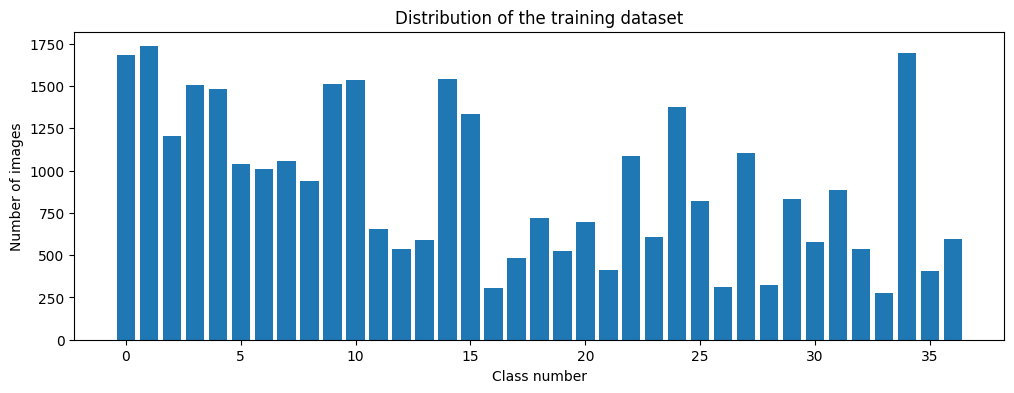

In [ ]:
# read the label data from csv file
labels = pandas.read_csv(LABEL_PATH) # read the labels csv file
print("data shape ", labels.shape, type(labels))

# display some sample images from each class
sample_x_class =  {} # list for the number of samples per class

# Loop through each directory in the provided path
for class_dir in range(n_classes):
    # Full path to the subdirectory
    full_path = os.path.join(TRAIN_PATH, str(class_dir))
    num_dir = {}

    # Only proceed if it's a directory
    if os.path.isdir(full_path):
        num_dir['id'] = class_dir
        num_dir['n'] = len(os.listdir(full_path))
        sample_x_class[class_dir] = num_dir

# print the number of samples per class with the class name
print(f"{sample_x_class}")

sample_x_class_values = [item['n'] for item in sample_x_class.values()]

# plot the distribution of training dataset
plt.figure(figsize=(12, 4))
plt.bar(range(0, n_classes), sample_x_class_values) # create a bar chart for sample distribution
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [32]:
X_train = numpy.array([img_to_array(load_img(img, target_size=IMG_DIM, color_mode='grayscale')) for img, label in train_dataset.imgs])
X_val = numpy.array([img_to_array(load_img(img, target_size=IMG_DIM, color_mode='grayscale')) for img, label in val_dataset.imgs])
X_test = numpy.array([img_to_array(load_img(img, target_size=IMG_DIM, color_mode='grayscale')) for img, label in test_dataset.imgs])

y_train = numpy.array([label for img, label in train_dataset.imgs])
y_val = numpy.array([label for img, label in val_dataset.imgs])
y_test = numpy.array([label for img, label in test_dataset.imgs])

# reshape the data to add a depth of 1 (grayscale images have only one channel)
X_train = X_train.reshape(X_train.shape[0], IMG_DIM[0], IMG_DIM[1], 1)
X_val = X_val.reshape(X_val.shape[0], IMG_DIM[0], IMG_DIM[1], 1)
X_test = X_test.reshape(X_test.shape[0], IMG_DIM[0], IMG_DIM[1], 1)

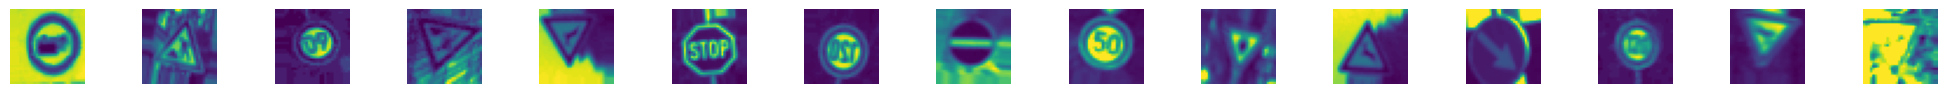

In [33]:
# create an image data generator for augmenting the training data
img_gen = ImageDataGenerator(width_shift_range=0.1, # randomly shift images horizontally by 10%
							height_shift_range=0.1, # randomly shift images vertically by 10%
							zoom_range=0.2, # randomly zoom in or out
							shear_range=0.1, # randomly shear the images
							rotation_range=10, # randomly rotate images by up to 10 degrees
							horizontal_flip=True,
							vertical_flip=True,
							brightness_range=(0.5, 1.5))
img_gen.fit(X_train) # fit the generator on the training data
batches = img_gen.flow(X_train, y_train, batch_size=20) # generate augmented images
X_batch, y_batch = next(batches) # get the next batch

# display some augmented images
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
for i in range(15):
	axs[i].imshow(X_batch[i].reshape(IMG_DIM[0], IMG_DIM[1])) # reshape to 32x32 and display
	axs[i].axis('off') # hide axis (for cleaner display)
plt.show()

# convert labels to one-hot encoded format
y_train = to_categorical(y_train, n_classes)
y_val = to_categorical(y_val, n_classes)
y_test = to_categorical(y_test, n_classes)

In [34]:
# Save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
	filepath="./best_model.keras", # File path to save the best model
	monitor="val_accuracy", # Metric to monitor
	mode="max", # 'max' since we want the highest validation accuracy
	save_best_only=True, # Save only when validation accuracy improves
	verbose=1 # Print a message when saving the model
)

# Stop training when validation accuracy has stopped improving for 'patience' epochs
early_stopping = EarlyStopping(
	monitor="val_accuracy", # Metric to monitor
	mode="max", # Stop when this metric stops improving
	patience=10, # Number of epochs with no improvement after which training will stop
	restore_best_weights=True, # Restore the weights of the best model at the end of training
	verbose=1 # Print a message when stopping
)

# build and train the model
model = TrafficSignModel(n_classes=n_classes, img_dim=IMG_DIM)
print(model.get_model().summary())

# train the model
history = model.get_model().fit(
	img_gen.flow(X_train, y_train, batch_size=BATCH_SIZE_VAL), # train the model using data augmentation
	steps_per_epoch=STEPS_X_EPOCH, # number of steps per epoch
	epochs=N_EPOCHS, # number of epochs
	validation_data=(X_val, y_val), # validation data
	shuffle=True, # shuffle data during training
	callbacks=[early_stopping, checkpoint] # use the early stopping callback
)

/Users/matt/Documents/GitHub/traffic-signs-classification/.env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 60)       │        32,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 60)       │        32,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 60)       │        32,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 60)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 60)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 240)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       120,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 37)             │        18,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 418,097 (1.59 MB)

 Trainable params: 418,097 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


/Users/matt/Documents/GitHub/traffic-signs-classification/.env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.0654 - loss: 3.6946
Epoch 1: val_accuracy improved from -inf to 0.27807, saving model to ./best_model.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 100s 187ms/step - accuracy: 0.0655 - loss: 3.6939 - val_accuracy: 0.2781 - val_loss: 2.4362
Epoch 2/100
  1/530 ━━━━━━━━━━━━━━━━━━━━ 1:40 189ms/step - accuracy: 0.2344 - loss: 2.6715

/opt/homebrew/Cellar/python@3.12/3.12.7/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: val_accuracy improved from 0.27807 to 0.27925, saving model to ./best_model.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2344 - loss: 2.6715 - val_accuracy: 0.2793 - val_loss: 2.4423
Epoch 3/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.2863 - loss: 2.4313
Epoch 3: val_accuracy improved from 0.27925 to 0.63832, saving model to ./best_model.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 104s 196ms/step - accuracy: 0.2864 - loss: 2.4308 - val_accuracy: 0.6383 - val_loss: 1.1432
Epoch 4/100
  1/530 ━━━━━━━━━━━━━━━━━━━━ 1:34 178ms/step - accuracy: 0.3750 - loss: 1.8815

2024-10-31 20:45:43.886919: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_accuracy improved from 0.63832 to 0.65206, saving model to ./best_model.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3750 - loss: 1.8815 - val_accuracy: 0.6521 - val_loss: 1.1262
Epoch 5/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4953 - loss: 1.5884
Epoch 5: val_accuracy improved from 0.65206 to 0.70322, saving model to ./best_model.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 1548s 3s/step - accuracy: 0.4954 - loss: 1.5882 - val_accuracy: 0.7032 - val_loss: 0.8782
Epoch 6/100
  1/530 ━━━━━━━━━━━━━━━━━━━━ 1:32 175ms/step - accuracy: 0.5938 - loss: 1.3092
Epoch 6: val_accuracy improved from 0.70322 to 0.71009, saving model to ./best_model.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5938 - loss: 1.3092 - val_accuracy: 0.7101 - val_loss: 0.8658
Epoch 7/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6099 - loss: 1.2154
Epoch 7: val_accuracy improved from 0.71009 to 0.83728, saving model to ./best_model.keras
530/530 ━━━━━━━━

2024-10-31 21:16:58.525462: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 12: val_accuracy improved from 0.87541 to 0.88086, saving model to ./best_model.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7344 - loss: 1.0694 - val_accuracy: 0.8809 - val_loss: 0.3277
Epoch 13/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.7631 - loss: 0.7519
Epoch 13: val_accuracy did not improve from 0.88086
530/530 ━━━━━━━━━━━━━━━━━━━━ 107s 201ms/step - accuracy: 0.7631 - loss: 0.7518 - val_accuracy: 0.8712 - val_loss: 0.3571
Epoch 14/100
  1/530 ━━━━━━━━━━━━━━━━━━━━ 1:57 223ms/step - accuracy: 0.7344 - loss: 0.8347
Epoch 14: val_accuracy did not improve from 0.88086
530/530 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7344 - loss: 0.8347 - val_accuracy: 0.8723 - val_loss: 0.3486
Epoch 15/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.7936 - loss: 0.6609
Epoch 15: val_accuracy improved from 0.88086 to 0.90976, saving model to ./best_model.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 107s 202ms/step - accuracy: 0.7936 - loss: 0.6609 - val

2024-10-31 21:31:55.375169: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 28: val_accuracy did not improve from 0.91994
530/530 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9062 - loss: 0.2626 - val_accuracy: 0.9185 - val_loss: 0.2118
Epoch 29/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8488 - loss: 0.4772
Epoch 29: val_accuracy did not improve from 0.91994
530/530 ━━━━━━━━━━━━━━━━━━━━ 107s 202ms/step - accuracy: 0.8488 - loss: 0.4771 - val_accuracy: 0.9176 - val_loss: 0.2177
Epoch 30/100
  1/530 ━━━━━━━━━━━━━━━━━━━━ 1:41 192ms/step - accuracy: 0.8906 - loss: 0.2992
Epoch 30: val_accuracy did not improve from 0.91994
530/530 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8906 - loss: 0.2992 - val_accuracy: 0.9162 - val_loss: 0.2207
Epoch 31/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8451 - loss: 0.4762
Epoch 31: val_accuracy improved from 0.91994 to 0.92231, saving model to ./best_model.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 107s 202ms/step - accuracy: 0.8451 - loss: 0.4762 - val_accuracy: 0.9223 - val_loss: 0.2143
Epo

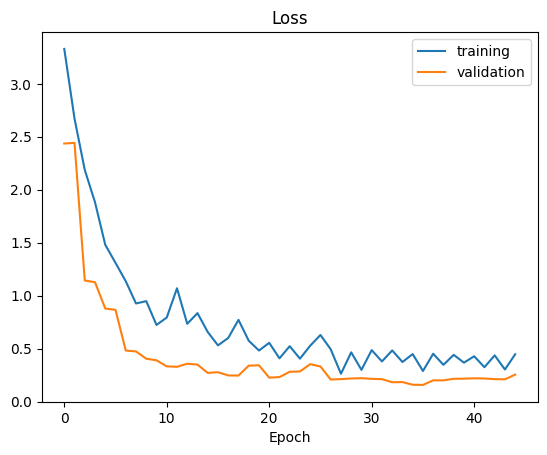

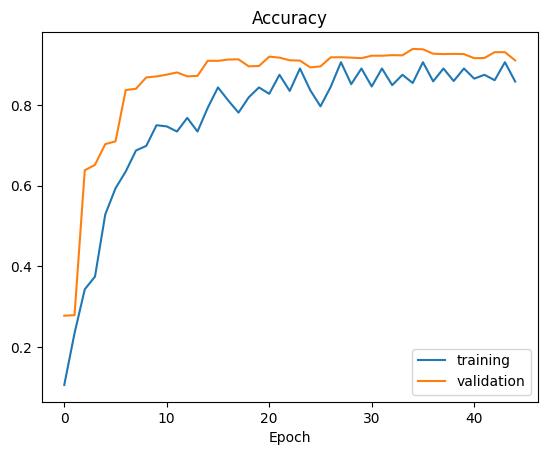

/Users/matt/Documents/GitHub/traffic-signs-classification/.env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Last Validation Loss from Saved Model: 0.15867647528648376
Last Validation Accuracy from Saved Model: 0.9391283988952637


In [35]:
# plot the training and validation loss
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

# plot the training and validation accuracy
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.show()

# print last validation loss and accuracy from saved model
model = TrafficSignModel(n_classes=n_classes, img_dim=IMG_DIM)
model.get_model().load_weights("./best_model.keras") # load the best model
loss, accuracy = model.get_model().evaluate(X_val, y_val, verbose=0) # evaluate the model
print(f'Last Validation Loss from Saved Model: {loss}')
print(f'Last Validation Accuracy from Saved Model: {accuracy}')

In [36]:
# save the trained model
pickle_out = open(RESULT_PATH + ".p", "wb")
print("Saving model to ", RESULT_PATH + ".p")
pickle.dump(model, pickle_out) # serialize and save the model
pickle_out.close()

import dill
# Save the model using dill
with open(RESULT_PATH + ".dill", "wb") as pickle_out:
	dill.dump(model, pickle_out)
print("Saving model to ", RESULT_PATH + ".dill")

Saving model to  dataloader_max_3x5-3x3_dataset_no0_530sxe_w_new_data.p
Saving model to  dataloader_max_3x5-3x3_dataset_no0_530sxe_w_new_data.dill
